In [46]:
import gzip
from collections import defaultdict
import math
import scipy.optimize
from sklearn import svm
import numpy as np
import string
import random
import string
import pandas as pd
from sklearn import linear_model
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import itertools
import ast
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import MultiLabelBinarizer



In [47]:
raw_Recipes = pd.read_csv('RAW_recipes.csv')
raw_Interactions = pd.read_csv('RAW_interactions.csv')

In [48]:
recipes_features = ['id', 'minutes', 'n_steps', 'nutrition']
raw_Recipes = raw_Recipes[recipes_features]

In [49]:
raw_Recipes['nutrition'] = raw_Recipes['nutrition'].apply(
    lambda x: ast.literal_eval(x)[0] if pd.notnull(x) and len(ast.literal_eval(x)) > 0 else None
)
raw_Recipes.rename(columns={'id': 'recipe_id'}, inplace=True)


In [50]:
merged_df = pd.merge(raw_Interactions, raw_Recipes, on='recipe_id', how='left')
filtered_data = merged_df[merged_df['minutes'] < 1440].copy()
filtered_data['length_review'] = filtered_data['review'].apply(lambda x: len(x) if pd.notnull(x) else 0)
filtered_data = filtered_data[filtered_data['length_review'] > 0]
filtered_data = filtered_data[filtered_data['nutrition'] < 5000]
filtered_data.reset_index(drop=True, inplace=True)
filtered_data['popular'] = filtered_data['rating'].apply(lambda x: 1 if x > 4 else 0)


In [39]:
training, remain = train_test_split(filtered_data, test_size=0.2, random_state=40)
validation, test = train_test_split(remain, test_size=0.5, random_state=40)

In [40]:
# Select features and target
features = ['minutes', 'n_steps', 'nutrition']
X_train = training[features]
y_train = training['popular']

X_val = validation[features]
y_val = validation['popular']

X_test = test[features]
y_test = test['popular']


,user_id,recipe_id,date,rating,review,minutes,n_steps,nutrition,tags,n_ingredients,length_review,popular,tag_count
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...,495,4,204.8,"[weeknight, time-to-make, course, main-ingredi...",9,138,0,13
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall...",495,4,204.8,"[weeknight, time-to-make, course, main-ingredi...",9,205,1,13
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...,20,5,132.3,"[30-minutes-or-less, time-to-make, course, mai...",4,99,0,43
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...,10,3,2786.2,"[15-minutes-or-less, time-to-make, course, mai...",13,68,1,11
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin...",10,3,2786.2,"[15-minutes-or-less, time-to-make, course, mai...",13,73,1,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1123246,116593,72730,2003-12-09,0,Another approach is to start making sauce with...,22,6,1941.7,"[30-minutes-or-less, time-to-make, course, mai...",6,105,0,19
1123247,583662,386618,2009-09-29,5,These were so delicious! My husband and I tru...,21,9,124.7,"[30-minutes-or-less, time-to-make, course, mai...",8,363,1,18
1123248,157126,78003,2008-06-23,5,WOW! Sometimes I don't take the time to rate ...,115,8,828.2,"[weeknight, time-to-make, course, preparation,...",10,577,1,10
1123249,53932,78003,2009-01-11,4,Very good! I used regular port as well. The ...,115,8,828.2,"[weeknight, time-to-make, course, preparation,...",10,115,0,10


In [41]:
# Scale features for better performance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Train logistic regression model
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

LogisticRegression()

In [42]:
# Predict on validation set
y_val_pred = model.predict(X_val_scaled)

# Evaluate the model
accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred)

print(f"Validation Accuracy: {accuracy:.2f}")
print(f"Validation Precision: {precision:.2f}")
print(f"Validation Recall: {recall:.2f}")
print(f"Validation F1 Score: {f1:.2f}")

Validation Accuracy: 0.72
Validation Precision: 0.72
Validation Recall: 1.00
Validation F1 Score: 0.84


In [43]:
X_test_scaled = scaler.transform(X_test)
y_test_pred = model.predict(X_test_scaled)

test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.2f}")


Test Accuracy: 0.72


In [44]:
# Print feature importance
feature_importance = pd.DataFrame({
    'Feature': features,
    'Coefficient': model.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

print(feature_importance)

     Feature  Coefficient
1    n_steps     0.023732
2  nutrition     0.001419
0    minutes    -0.037835


In [53]:
features = ['minutes', 'n_steps', 'nutrition', 'length_review']
X_train = training[features]
y_train = training['popular']

X_val = validation[features]
y_val = validation['popular']

X_test = test[features]
y_test = test['popular']

In [54]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Train logistic regression
log_reg = LogisticRegression()
log_reg.fit(X_train_scaled, y_train)

# Validate the model
y_val_pred = log_reg.predict(X_val_scaled)
print(f"Validation Accuracy: {accuracy_score(y_val, y_val_pred):.2f}")
print(f"Validation Precision: {precision_score(y_val, y_val_pred):.2f}")
print(f"Validation Recall: {recall_score(y_val, y_val_pred):.2f}")
print(f"Validation F1 Score: {f1_score(y_val, y_val_pred):.2f}")

Validation Accuracy: 0.72
Validation Precision: 0.72
Validation Recall: 1.00
Validation F1 Score: 0.84


In [55]:
feature_importance = pd.DataFrame({
    'Feature': features,
    'Coefficient': log_reg.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

print(feature_importance)


         Feature  Coefficient
1        n_steps     0.023952
2      nutrition    -0.003029
3  length_review    -0.029402
0        minutes    -0.035600


In [19]:
filtered_data['tag_count'] = filtered_data['tags'].apply(
    lambda x: len(ast.literal_eval(x)) if pd.notnull(x) else 0
)

In [20]:
filtered_data

,user_id,recipe_id,date,rating,review,minutes,n_steps,nutrition,tags,n_ingredients,length_review,popular,tag_count
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...,495,4,204.8,"['weeknight', 'time-to-make', 'course', 'main-...",9,138,0,13
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall...",495,4,204.8,"['weeknight', 'time-to-make', 'course', 'main-...",9,205,1,13
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...,20,5,132.3,"['30-minutes-or-less', 'time-to-make', 'course...",4,99,0,43
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...,10,3,2786.2,"['15-minutes-or-less', 'time-to-make', 'course...",13,68,1,11
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin...",10,3,2786.2,"['15-minutes-or-less', 'time-to-make', 'course...",13,73,1,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1123246,116593,72730,2003-12-09,0,Another approach is to start making sauce with...,22,6,1941.7,"['30-minutes-or-less', 'time-to-make', 'course...",6,105,0,19
1123247,583662,386618,2009-09-29,5,These were so delicious! My husband and I tru...,21,9,124.7,"['30-minutes-or-less', 'time-to-make', 'course...",8,363,1,18
1123248,157126,78003,2008-06-23,5,WOW! Sometimes I don't take the time to rate ...,115,8,828.2,"['weeknight', 'time-to-make', 'course', 'prepa...",10,577,1,10
1123249,53932,78003,2009-01-11,4,Very good! I used regular port as well. The ...,115,8,828.2,"['weeknight', 'time-to-make', 'course', 'prepa...",10,115,0,10


In [21]:
largest_n_steps = filtered_data['n_steps'].max()
largest_nutrition = filtered_data['nutrition'].max()

print(f"Largest n_steps: {largest_n_steps}")
print(f"Largest nutrition: {largest_nutrition}")

Largest n_steps: 145
Largest nutrition: 434360.2


In [24]:
filtered_data = filtered_data[filtered_data['nutrition'] < 5000]
largest_nutrition = filtered_data['nutrition'].max()
print(f"Largest nutrition: {largest_nutrition}")

Largest nutrition: 4997.8


In [ ]:
# Parse tags into lists
filtered_data['tags'] = filtered_data['tags'].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) else [])
mlb = MultiLabelBinarizer()
tag_features = pd.DataFrame(mlb.fit_transform(filtered_data['tags']), columns=mlb.classes_, index=filtered_data.index)

# Merge one-hot-encoded tags into filtered_data
filtered_data = pd.concat([filtered_data, tag_features], axis=1)

In [ ]:
# Add 'tag_count' as a feature
features = ['minutes', 'n_steps', 'nutrition', 'length_review', 'n_ingredients', 'tag_count']

# Or, if one-hot-encoded tags are used, include those columns
features += list(tag_features.columns)

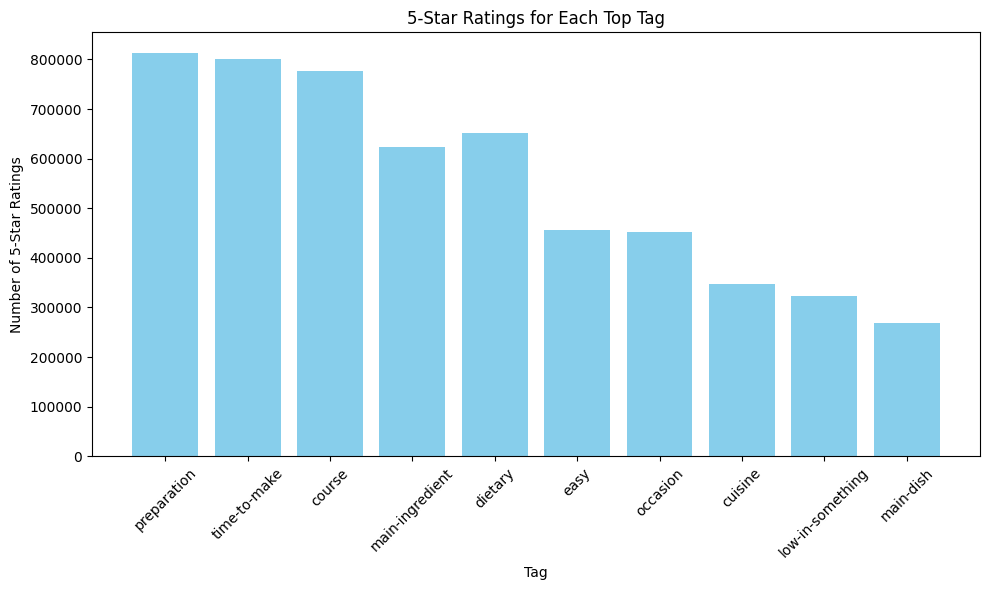

In [5]:
# Load datasets (update paths if needed)
raw_recipes = pd.read_csv('RAW_recipes.csv')
raw_interactions = pd.read_csv('RAW_interactions.csv')

# Clean and process tags in raw_recipes
raw_recipes['tags'] = raw_recipes['tags'].str.strip("[]").str.replace("'", "").str.split(", ")

# Merge the recipes and interactions datasets on the recipe ID
merged_data = pd.merge(raw_interactions, raw_recipes, left_on='recipe_id', right_on='id')

# Define the top tags
top_tags = ['preparation', 'time-to-make', 'course', 'main-ingredient', 'dietary', 
            'easy', 'occasion', 'cuisine', 'low-in-something', 'main-dish']

# Initialize a dictionary to store the count of 5-star ratings for each top tag
five_star_ratings = {}

for tag in top_tags:
    # Filter recipes containing the specific tag
    tag_recipes = merged_data[merged_data['tags'].apply(lambda x: tag in x if isinstance(x, list) else False)]
    # Count the number of 5-star ratings for the tag
    five_star_count = tag_recipes[tag_recipes['rating'] == 5].shape[0]
    five_star_ratings[tag] = five_star_count

# Create a DataFrame for plotting
five_star_df = pd.DataFrame(list(five_star_ratings.items()), columns=['Tag', '5-Star Ratings'])

# Plot the number of 5-star ratings for each top tag
plt.figure(figsize=(10, 6))
plt.bar(five_star_df['Tag'], five_star_df['5-Star Ratings'], color='skyblue')
plt.title('5-Star Ratings for Each Top Tag')
plt.xlabel('Tag')
plt.ylabel('Number of 5-Star Ratings')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


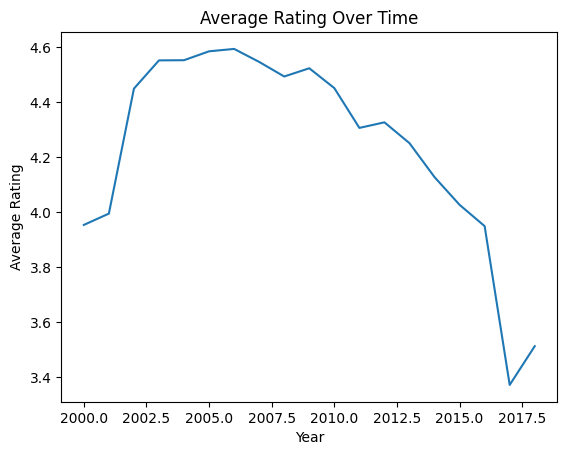

In [31]:
raw_interactions['year'] = pd.to_datetime(raw_interactions['date']).dt.year
avg_rating_by_year = raw_interactions.groupby('year')['rating'].mean()

plt.plot(avg_rating_by_year.index, avg_rating_by_year.values)
plt.title("Average Rating Over Time")
plt.xlabel("Year")
plt.ylabel("Average Rating")
plt.show()

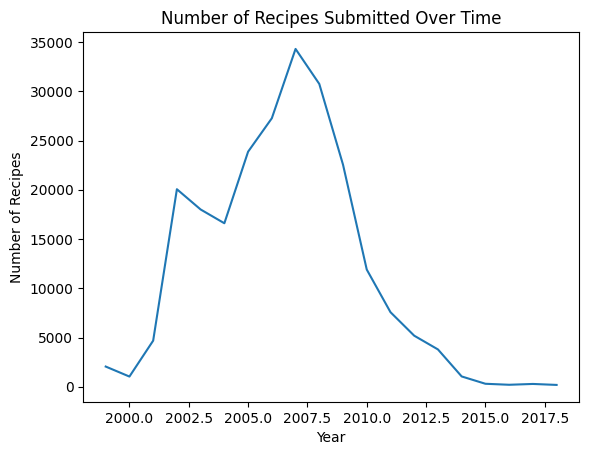

In [32]:
raw_recipes['year'] = pd.to_datetime(raw_recipes['submitted']).dt.year
recipes_by_year = raw_recipes['year'].value_counts().sort_index()

plt.plot(recipes_by_year.index, recipes_by_year.values)
plt.title("Number of Recipes Submitted Over Time")
plt.xlabel("Year")
plt.ylabel("Number of Recipes")
plt.show()
